# What can a recurrent network learn?

In this exercise, we will construct a set of simple strings, and train a LSTM network, and see what sequence-concepts these networks can learn. 

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import random

# A set of simple strings

## Remembering state

In these strings, we will generate random letters, but any letter following the S must be the same as the letter following the previous R

First, let's revise some Python to figure out how to generate these strings.

(Later on, you can vary this function to compute different types of strings, to see what a LSTM net can do. ) 

Now we put all these functions together into a function to generate a set of strings and their 0/1 labels

This will be used to generate training and test data. 

*** after using this version, you should change this function (or define another function) to generate strings of a different type, and then go through the worksheet again ****

In [4]:
def generate_RS_memory_strings(n_strings, string_length, charset):
    """
    n_strings : number of strings to generate
    n : length of the string to be generated
    charset : set of characters to use
    specialchar : the memorize symbol (a character)
    valid : boolean - memorisation correct if True, incorrect if false
    """
    char_list = list( charset )
    string_label = {}

    for s_counter in range(0,n_strings):
        label = random.randint(0,1)
        this_string_list = []
        
        Rpos1 = random.randint(0,string_length-2) # last possible position is second-last character
        Rpos2 = random.randint(0,string_length-2)
        while np.abs(Rpos1 - Rpos2) < 2:
            Rpos2 = random.randint(0,string_length-2)
        if Rpos1 > Rpos2:
            Rpos1, Rpos2 = (Rpos2, Rpos1) # in python you can swap variable values like this
        for i in range(0,string_length):
            this_string_list.append( random.choice( char_list ) )
        this_string_list[Rpos1] = 'R'
        this_string_list[Rpos2] = 'S'
        if label: 
            this_string_list[Rpos2+1] = this_string_list[Rpos1+1] # memory and correct recall !
        else:
            while this_string_list[Rpos2+1] == this_string_list[Rpos1+1]:
                this_string_list[Rpos2+1] = random.choice( char_list )
        if string_label.get(''.join( this_string_list )) is None:
            string_label[ ''.join( this_string_list ) ] = label
            #print(string_label)
    
    return list(string_label.keys()), list(string_label.values())
        

In [5]:
# Test the function ! 
# make sure the class labels are what is wanted. (Make sure you understanda what the class labels mean here.)

ss, ss_labels = generate_RS_memory_strings(10, 8, 'abc')
ss, ss_labels

(['baaRaSbb',
  'RcccSbcc',
  'bRacSbbb',
  'cbRaScbb',
  'aRcaScca',
  'RcccaSca',
  'RbSbbaca',
  'aaaRaSba',
  'cRaccSab',
  'acRbbSbb'],
 [0, 0, 0, 0, 1, 1, 1, 0, 1, 1])

Constructing a dict that maps characters in a string to numbers, counting up from 1:

In [6]:
# This constructs and returns two dicts, that can be used to map the characters that are in the string
# to ints, and those ints back to the characters

def char_to_integers( mystring ):
    charlist = list( set( list( mystring )))
    nums = range(1,len(charlist)+1)
    c2ndict = dict()
    n2cdict = dict()
    for c,n in zip(charlist,nums):
        c2ndict[c]=n
        n2cdict[n]=c
    return c2ndict, n2cdict

In [7]:
# test it
char_to_integers('elephant')

({'e': 1, 't': 2, 'p': 3, 'h': 4, 'a': 5, 'n': 6, 'l': 7},
 {1: 'e', 2: 't', 3: 'p', 4: 'h', 5: 'a', 6: 'n', 7: 'l'})

In [8]:
def string_to_int_vec( s, pad_length, code_dict):
    """
    Converts a string to a vector of ints, using a character-encoding dictionary
    
    s : the string to convert
    padlength : the length to pad the string to, with initial zeros
    code : dict giving the conversion from chars to integers
    """
    slen = len(s)
    assert slen <= pad_length
    v = np.zeros([pad_length])
    startx = pad_length - slen
    stringlist = list(s)
    for i in range(0,slen):
        v[startx + i] = code_dict[stringlist[i]]
    return v
    

In [9]:
def strings_to_nparray(strings, pad_length, char_to_integers):
    """
    Converts a lest of strings to an numpy array, which can be used as training
    or testing data
    
    strings : a list of strings
    maxlen  : an integer, greater than or equal to the max length of any of the strings
    
    This function converts a list of n strings into a n x maxlen numpy array, containing
    the coded strings
    """
    mat = np.zeros([len(strings),pad_length])
    for i in range(0,len(strings)):
        mat[i,:] = string_to_int_vec( strings[i], pad_length, char_to_integers )
    return mat


In [10]:
c2i,i2c = char_to_integers(''.join(ss))
c2i

{'b': 1, 'c': 2, 'a': 3, 'R': 4, 'S': 5}

In [11]:
# test strings_to_nparray

data = strings_to_nparray(ss,8,c2i)
data

array([[1., 3., 3., 4., 3., 5., 1., 1.],
       [4., 2., 2., 2., 5., 1., 2., 2.],
       [1., 4., 3., 2., 5., 1., 1., 1.],
       [2., 1., 4., 3., 5., 2., 1., 1.],
       [3., 4., 2., 3., 5., 2., 2., 3.],
       [4., 2., 2., 2., 3., 5., 2., 3.],
       [4., 1., 5., 1., 1., 3., 2., 3.],
       [3., 3., 3., 4., 3., 5., 1., 3.],
       [2., 4., 3., 2., 2., 5., 3., 1.],
       [3., 2., 4., 1., 1., 5., 1., 1.]])

In [12]:
# a useful checking function is to do the back-conversion

def int_vec_to_string(v,i2c):
    """
    v : an array of ints, possibly with initial zeros to be ignored
    i2c : a dict mapping ints to chars
    """
    charlist = []
    i = 0 
    for i in range(0,v.shape[0]):
        if v[i] > 0:
            charlist.append( i2c[v[i]] )
    return ''.join(charlist)

In [13]:
# now we can check the conversions
# the original string and its back-conversion from its vector-coding should be the same
ss[2], int_vec_to_string(data[2,:],i2c), ss_labels[2]

('bRacSbbb', 'bRacSbbb', 0)

# Tokenizing and preparing datasets

In [14]:
pad_length = 10

In [15]:
training_strings, training_label_list = generate_RS_memory_strings(5000, pad_length, set('ab'))

In [17]:
training_strings[:5], training_label_list[:5]

(['abbaRbaSbb', 'babbRbSaaa', 'abRbabSbbb', 'bbRabbbSab', 'aRbaaSaaab'],
 [1, 0, 1, 1, 0])

In [18]:
y_train = np.asarray(training_label_list)

In [19]:
y_train.shape

(3624,)

In [20]:
# this inefficiently ensures that we have complete character codinng and decoding
# dictionaries by scanning through the entire training set
c2i, i2c = char_to_integers(''.join(training_strings))
n_chars = len( c2i ) + 1 # we leave 0 as the padding symbol

In [21]:
x_train = strings_to_nparray(training_strings, pad_length, c2i)
x_test = strings_to_nparray(test_strings, pad_length, c2i)
(x_train.shape, x_test.shape)

((3624, 10), (3597, 10))

# Learning and Testing

In [22]:
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.layers import Embedding, Attention
from tensorflow.keras.layers import LSTM, SimpleRNN



In [23]:
n_chars  # the number of different characters used in the training set strings

5

In [24]:
embedding_matrix = np.eye(n_chars+1)
embedding_matrix

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

## Visualising the outputs of the LSTM layer during the sequence

Let us check to see if the LSTM works for sequences of different lengths, even though we only trained it on sequences of length 10. And let use visualise the output of the LSTM layer at all stages of sequence processing. 

To do this visualisation, we will transfer the weights from the model we trained to a different model, which we use only for visualisation

#### Investigation:  Now compare the heatmaps generated when you change one character of viz_string. Try changing characters that don't matter, and also characters that do, and see what changes happen in the outputs of the LSTM layer. 

*** Self-help: can you look up in the matplotlib documentation (or google) to put the letters of the viz_string along the x-axis of the heatmap? This would make it easier to see what outputs are changing when ***

Exercise: use the model_for_viz outputs as a matrix and multiply the matrix with these weights, to get the input to the last layer of the model at each character of the sequence. 

In [51]:
# Variable-length int sequences.
query_input = Input((pad_length,))

# Embedding lookup.
token_embedding = Embedding(n_chars+1, output_dim=n_chars+1, name='embedding')
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)

# LSTM layer.
lstm_layer = LSTM(50)
# Query encoding of shape [batch_size, Tq, filters].
lstm_output = lstm_layer(query_embeddings)
dense_layer = Dense(1, activation='sigmoid')(lstm_output)

In [52]:
model = Model(query_input, dense_layer)

In [53]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 6)             36        
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                11400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 11,487
Trainable params: 11,487
Non-trainable params: 0
_________________________________________________________________


In [54]:
embedding_matrix = np.eye(n_chars+1)
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [55]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [56]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_split=0.2)

Train on 2899 samples, validate on 725 samples
Epoch 1/50
2899/2899 [==============================] - 2s 840us/sample - loss: 0.6935 - accuracy: 0.5036 - val_loss: 0.6928 - val_accuracy: 0.5186
Epoch 2/50
2899/2899 [==============================] - 0s 133us/sample - loss: 0.6916 - accuracy: 0.5309 - val_loss: 0.6895 - val_accuracy: 0.5559
Epoch 3/50
2899/2899 [==============================] - 0s 134us/sample - loss: 0.6861 - accuracy: 0.5592 - val_loss: 0.6821 - val_accuracy: 0.5586
Epoch 4/50
2899/2899 [==============================] - 0s 127us/sample - loss: 0.6792 - accuracy: 0.5678 - val_loss: 0.6799 - val_accuracy: 0.5572
Epoch 5/50
2899/2899 [==============================] - 0s 136us/sample - loss: 0.6774 - accuracy: 0.5692 - val_loss: 0.6759 - val_accuracy: 0.5641
Epoch 6/50
2899/2899 [==============================] - 0s 151us/sample - loss: 0.6751 - accuracy: 0.5726 - val_loss: 0.6762 - val_accuracy: 0.5655
Epoch 7/50
2899/2899 [==============================] - 0s 137us/

In [31]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

In [32]:
# Attention Layer from Bahdanau et. al 
# https://arxiv.org/abs/1409.0473
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)
        
    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()
    

In [42]:
# Variable-length int sequences.
query_input_att = Input((pad_length,))

# Embedding lookup.
token_embedding_att = Embedding(n_chars+1, output_dim=n_chars+1, name='embedding')
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings_att = token_embedding_att(query_input_att)

# LSTM layer.
lstm_layer_att = LSTM(50, return_sequences=True)
# Query encoding of shape [batch_size, Tq, filters].
att_in = lstm_layer_att(query_embeddings_att)
att_out= attention()(att_in)
dense_layer = Dense(1, activation='sigmoid')(att_out)

In [43]:
model_att = Model(query_input_att, dense_layer)

In [44]:
model_att.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 6)             36        
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            11400     
_________________________________________________________________
attention_1 (attention)      (None, 50)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,547
Trainable params: 11,547
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_att.layers[1].set_weights([embedding_matrix])
model_att.layers[1].trainable = False

In [46]:
model_att.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [47]:
history = model_att.fit(x_train, y_train, batch_size=64, epochs=50,validation_split=0.2)

Train on 2899 samples, validate on 725 samples
Epoch 1/50
2899/2899 [==============================] - 3s 899us/sample - loss: 0.6934 - accuracy: 0.5095 - val_loss: 0.6930 - val_accuracy: 0.5103
Epoch 2/50
2899/2899 [==============================] - 0s 137us/sample - loss: 0.6929 - accuracy: 0.5185 - val_loss: 0.6929 - val_accuracy: 0.5090
Epoch 3/50
2899/2899 [==============================] - 0s 135us/sample - loss: 0.6921 - accuracy: 0.5229 - val_loss: 0.6929 - val_accuracy: 0.5159
Epoch 4/50
2899/2899 [==============================] - 0s 135us/sample - loss: 0.6908 - accuracy: 0.5326 - val_loss: 0.6916 - val_accuracy: 0.5241
Epoch 5/50
2899/2899 [==============================] - 0s 148us/sample - loss: 0.6882 - accuracy: 0.5405 - val_loss: 0.6904 - val_accuracy: 0.5310
Epoch 6/50
2899/2899 [==============================] - 0s 146us/sample - loss: 0.6864 - accuracy: 0.5436 - val_loss: 0.6879 - val_accuracy: 0.5393
Epoch 7/50
2899/2899 [==============================] - 0s 138us/

In [57]:
a = model.history.history['val_accuracy']

In [58]:
b = model_att.history.history['val_accuracy']

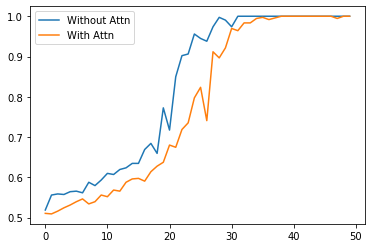

In [59]:
plt.plot(range(50), a,b)
plt.legend(['Without Attn', 'With Attn'])

In [46]:
pred = model_att.predict(x_test[:10,:])
print([int(p[0]>0.5) for p in pred])
y_test[:10]

[0, 1, 0, 0, 1, 1, 0, 1, 1, 0]


array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0])

In [47]:
# Now let us define a string for which we will visualise the outputs of the LSTM layer. 
# Let's use a string of length 19, say.  How long can you make this string so that the original 
# model still works?  

viz_string = 'abRabababaSbbb'
viz_vector = string_to_int_vec(viz_string, len(viz_string), c2i)
viz_vector = viz_vector.reshape([1,viz_vector.shape[0]]) # this makes it a data set of size 1
print(viz_vector)
print(viz_vector.shape)

[[4. 2. 3. 4. 2. 4. 2. 4. 2. 4. 1. 2. 2. 2.]]
(1, 14)


In [48]:
model.predict(viz_vector)

ValueError: Error when checking input: expected input_1 to have shape (10,) but got array with shape (14,)